<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/DefaultPredictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install lasio
!pip install md_toc

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

In [12]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git


fatal: destination path 'Volve-Well-Log-Prediction' already exists and is not an empty directory.


In [13]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [15]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


In [16]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

In [17]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.189869,-1.367969,0.837247,-0.816586,-1.441155,-2.286221,1.367432,15_9-F-11A,2600.4


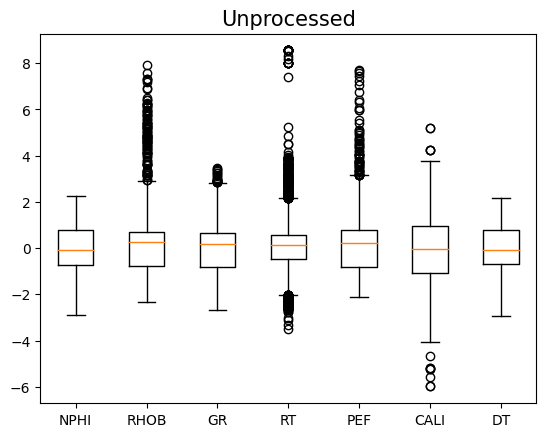

n samples unprocessed: 24403


In [18]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

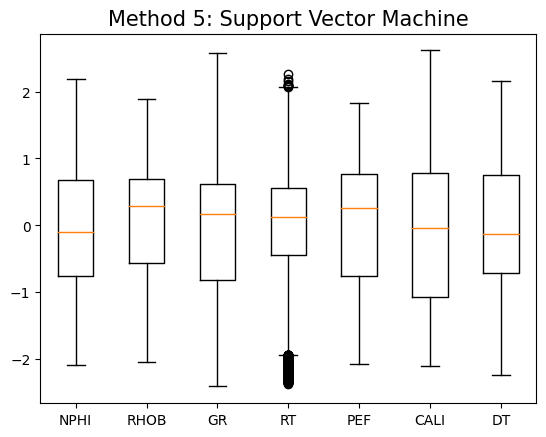

Remaining samples: 21964


In [19]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Method 5: Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [24]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


In [25]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values
y_train = train_svm[target_name].values

#Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
  # Split the df by log name
  val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]]

  # Drop name column
  val = val.drop(['WELL'], axis=1)

  # Define X_val (feature) and y_val (target)
  X_val_, y_val_ = val[feature_names].values, val[target_name].values

  X_val.append(X_val_)
  y_val.append(y_val_)

# save into separate dfs
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Booster object
model = GradientBoostingRegressor()

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Validation: Predict on well 1
y_pred1 = model.predict(X_val1)
print("R2 Log 1: {}".format(round(model.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3 = model.predict(X_val3)
print("R2 Log 3: {}".format(round(model.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4 = model.predict(X_val4)
print("R2 Log 4: {}".format(round(model.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4))
print("RMSE Log 4: {}".format(round(rmse,4)))

R2 Log 1: 0.9528
RMSE Log 1: 0.2335
R2 Log 3: 0.9429
RMSE Log 3: 0.221
R2 Log 4: 0.8958
RMSE Log 4: 0.2459


In [27]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1, y_pred1 = scaler.inverse_transform(y_val1.reshape(-1,1)), scaler.inverse_transform(y_pred1.reshape(-1,1))
y_val3, y_pred3 = scaler.inverse_transform(y_val3.reshape(-1,1)), scaler.inverse_transform(y_pred3.reshape(-1,1))
y_val4, y_pred4 = scaler.inverse_transform(y_val4.reshape(-1,1)), scaler.inverse_transform(y_pred4.reshape(-1,1))


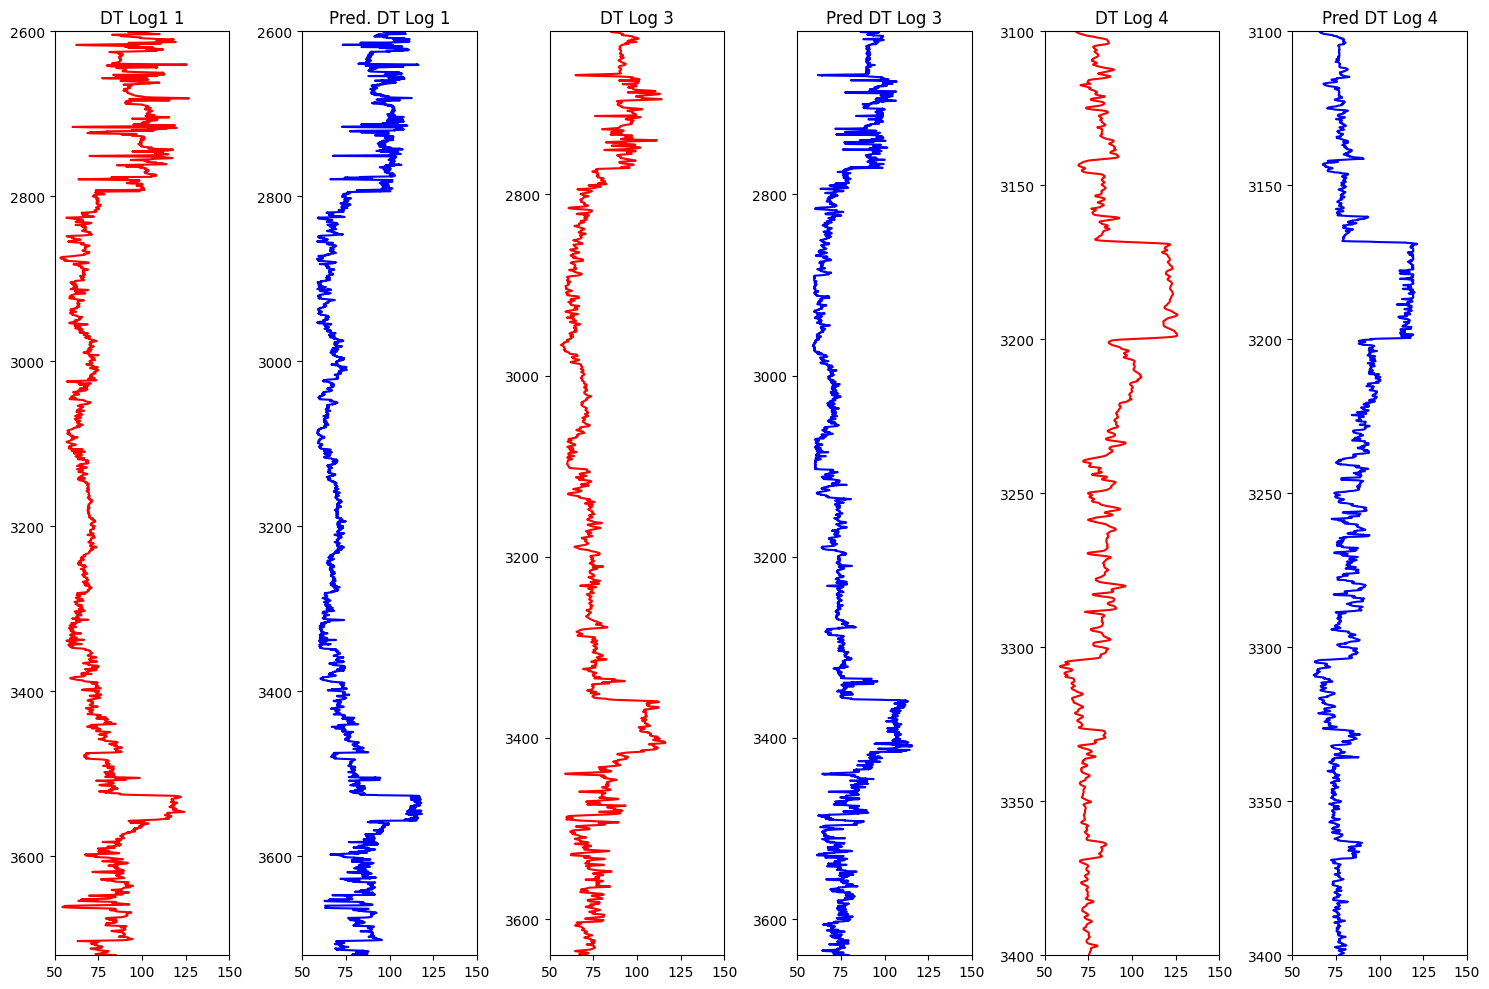

In [28]:
x = [y_val1, y_pred1, y_val3, y_pred3, y_val4, y_pred4]
y = [log1['DEPTH'], log1['DEPTH'], log3['DEPTH'], log3['DEPTH'], log4['DEPTH'], log4['DEPTH']]

color = ['red', 'blue', 'red', 'blue', 'red', 'blue']
title = ['DT Log1 1', 'Pred. DT Log 1', 'DT Log 3', 'Pred DT Log 3',
         'DT Log 4', 'Pred DT Log 4']

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i in range(len(x)):
  ax[i].plot(x[i], y[i], color=color[i])
  ax[i].set_xlim(50, 150)
  ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
  ax[i].set_title(title[i])

plt.tight_layout()

plt.show()

In [30]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [31]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

# Predict to log 2 and 5 with tuned model
y_pred2 = model.predict(X_test2)
y_pred5 = model.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_pred5 = scaler.inverse_transform(y_pred5.reshape(-1,1))

In [35]:
log2['DT'] = y_pred2
log5['DT'] = y_pred5

<ipython-input-35-230b2c9a40ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT'] = y_pred5


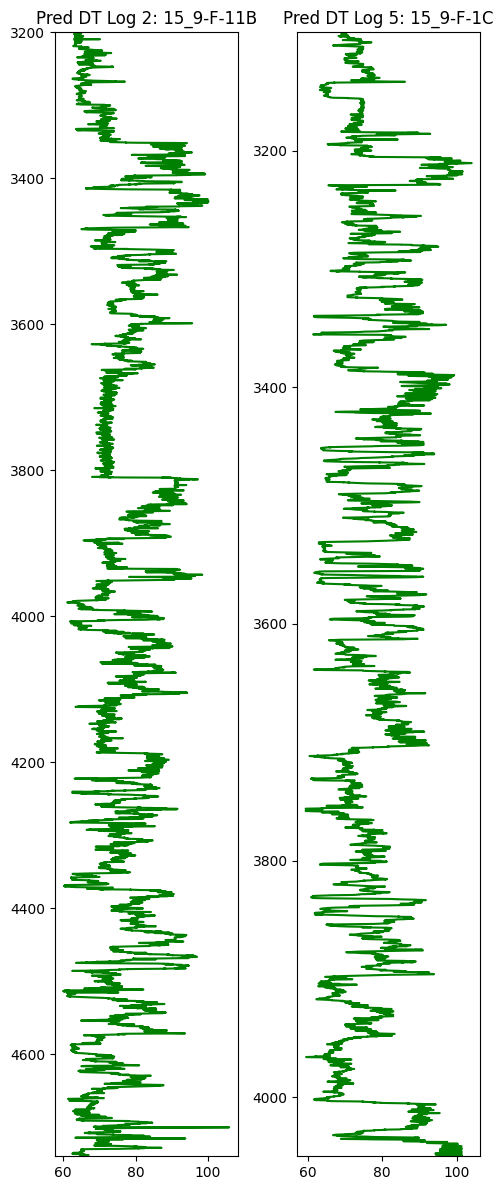

In [32]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred2, depth2, color='green')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)

plt.subplot(1,2,2)
plt.plot(y_pred5, depth5, color='green')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)

plt.tight_layout()
plt.show()

In [37]:
def makeplotpred(df,suptitle_str="pass a suptitle"):
  # Column selection from df
  col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
  # Plotting titles
  title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT']
  # plotting colors
  colors = ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green']

  # Create the subplots; ncols equals the number of logs
  fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(15,10))
  fig.suptitle(suptitle_str, size=20, y=1.05)

  # Looping each log to display in the subplots
  for i in range(len(col_names)):
    if i == 3:
      # for resistivity, semilog plot
      ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=colors[i])
    else:
      # for non-resistivity, normal plot
      ax[i].plot(df[col_names[i]], df['DEPTH'], color=colors[i])

    ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
    ax[i].set_title(title[i], pad=15)
    ax[i].grid(True)

  ax[2].set_xlim(0, 200)
  plt.tight_layout()
  plt.show()

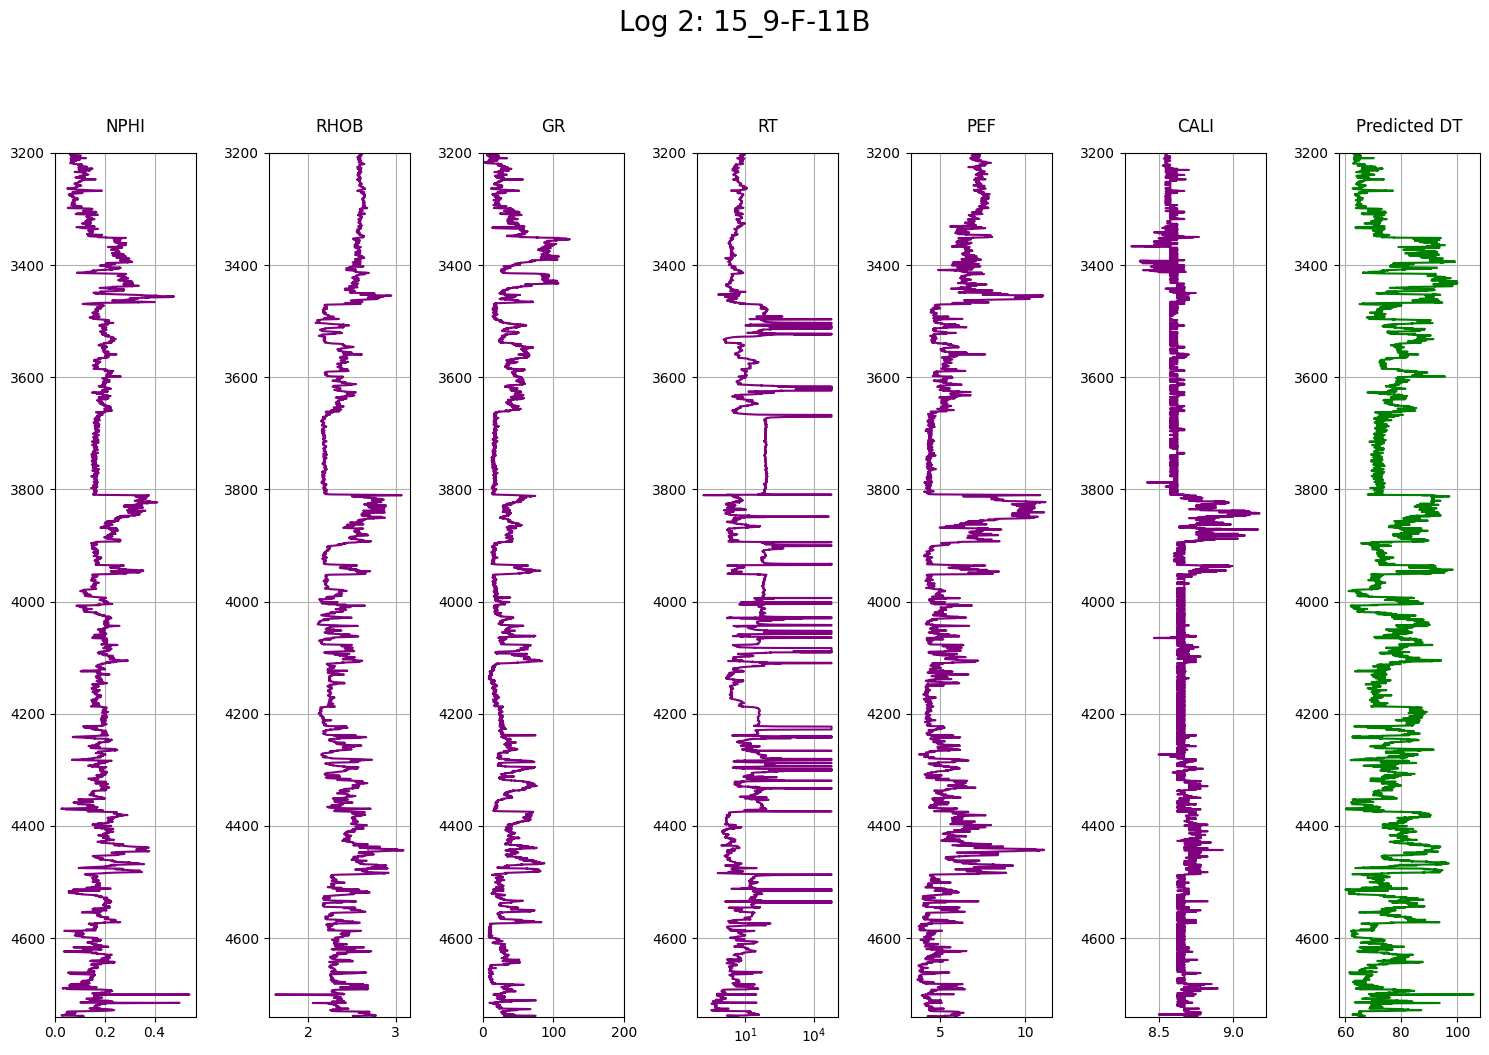

In [38]:
makeplotpred(log2,"Log 2: 15_9-F-11B")


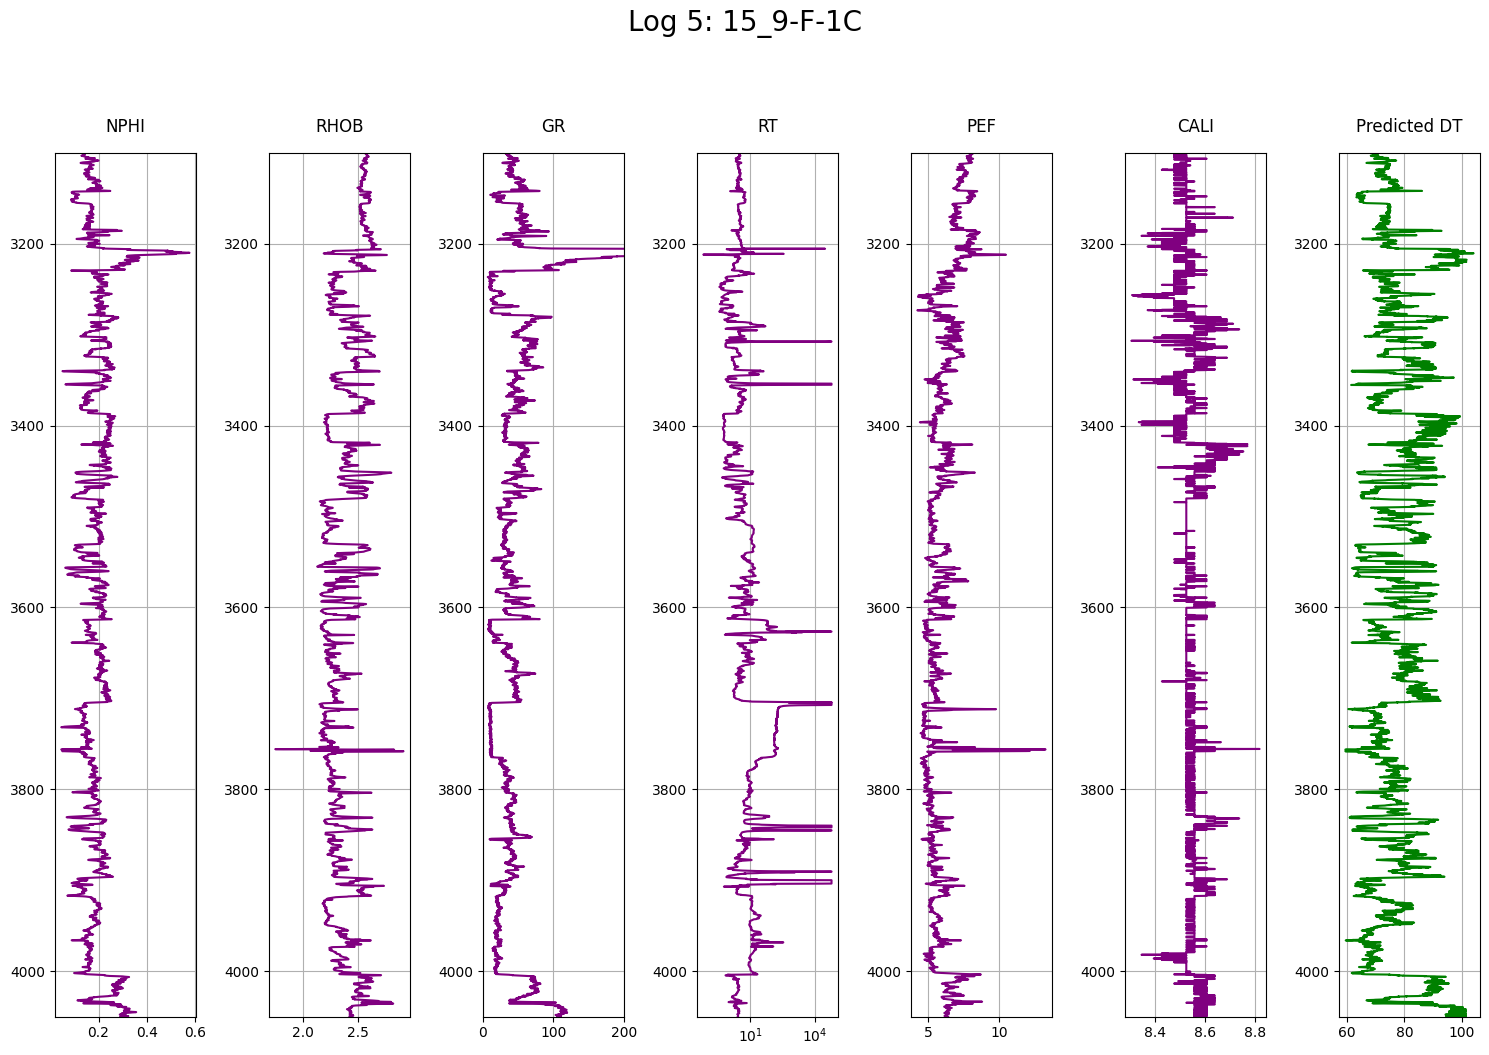

In [39]:
makeplotpred(log5,"Log 5: 15_9-F-1C")
